In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Optional: pretty tables in Jupyter
from IPython.display import display

# Set your path here if different
csv_path = "Dataset/cic_challenge_data_set.csv"
df = pd.read_csv(csv_path)
# Quick look

display(df.head())
display(pd.DataFrame({"column": df.columns}))

,state_ID,State_,Tot_Pop,Year,Pop_Dist_White,Pop_Dist_Black,Pop_Dist_Hispanic,Pop_Dist_Asian,Pop_Dist_Am_In,Pop_Dist_Nat_Haw_Pac_Isl,...,snap_tot_ben_Mil,SNAP_no_rep,Pov_Ad_Ch,Pov_Ad_No,Pov_Ad_Tot,Ad_Poor_MH_zero,Ad_Poor_MH_four,Ad_Poor_MH_thirteen,Ad_Poor_MH_fourteen,Cov_Vacc_one
0,1,Alabama,5049196,2021,64,26,5,1,0,0,...,1974053519,776479.08,14,15,15,60,12,12,16,1.166205e+08
1,2,Alaska,734420,2021,58,3,7,7,14,2,...,288045258,54650.50,10,11,11,62,14,11,13,6.131410e+08
2,3,Arizona,7274078,2021,52,4,32,3,3,0,...,2175824745,898016.08,12,12,12,61,14,11,14,4.359704e+08
3,4,Arkansas,3026870,2021,68,14,8,1,0,0,...,765794046,249708.75,15,15,15,62,12,10,16,1.145999e+09
4,5,California,39142565,2021,34,5,40,15,0,0,...,11243441465,5217210.83,11,11,11,59,15,12,14,7.499487e+09


,column
0,state_ID
1,State_
2,Tot_Pop
3,Year
4,Pop_Dist_White
5,Pop_Dist_Black
6,Pop_Dist_Hispanic
7,Pop_Dist_Asian
8,Pop_Dist_Am_In
9,Pop_Dist_Nat_Haw_Pac_Isl


In [4]:
# Drop identifier columns not useful for regression (ignore if missing)
data = df.drop(columns=["state_ID", "State_"], errors="ignore")

# Keep rows where Tot_GSP_Mil is present for models using that target
data_clean = data.dropna(subset=["Tot_GSP_Mil"]).copy()

print("Rows in data:", len(data))
print("Rows in data_clean (Tot_GSP_Mil not null):", len(data_clean))
print("Nulls per column (top 10):")
display(data_clean.isna().sum().sort_values(ascending=False).head(10))

Rows in data: 153
Rows in data_clean (Tot_GSP_Mil not null): 153
Nulls per column (top 10):


Cov_Vacc_one                3
Year                        0
Tot_Pop                     0
Pop_Dist_Black              0
Pop_Dist_Hispanic           0
Pop_Dist_Asian              0
Pop_Dist_Am_In              0
Pop_Dist_Nat_Haw_Pac_Isl    0
Pop_Dist_Mult_race          0
Povbr_White                 0
dtype: int64

In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Correlation with Tot_GSP_Mil
corrs = (
    data_clean
    .drop(columns=["Tot_GSP_Mil"])
    .corrwith(data_clean["Tot_GSP_Mil"])
    .sort_values(key=abs, ascending=False)
)
display(corrs.to_frame("corr_with_Tot_GSP_Mil").head(20))

# VIF on numeric predictors (drop non-numeric/NaNs)
X_num = data_clean.drop(columns=["Tot_GSP_Mil"]).select_dtypes(include=[np.number]).dropna()
vif_df = pd.DataFrame({
    "Variable": X_num.columns,
    "VIF": [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]
}).sort_values("VIF", ascending=False)
display(vif_df.head(20))

,corr_with_Tot_GSP_Mil
Tot_Pop,0.974339
snap_tot_ben_Mil,0.965193
SNAP_no_rep,0.961927
Mean_Unempl,0.938048
Pop_Dist_Hispanic,0.543610
Cov_Vacc_one,0.471673
Pop_Dist_White,-0.429386
Pop_Dist_Asian,0.286751
Pop_Dist_Am_In,-0.234882
Pov_Ad_No,-0.168602


,Variable,VIF
1,Year,25758.132846
2,Pop_Dist_White,11787.636744
20,Pov_Ad_Tot,1638.199517
19,Pov_Ad_No,825.390659
4,Pop_Dist_Hispanic,726.487725
3,Pop_Dist_Black,583.283420
22,Ad_Poor_MH_four,305.143228
18,Pov_Ad_Ch,303.394893
9,Povbr_White,217.270047
23,Ad_Poor_MH_thirteen,215.420568


In [7]:
reduced_predictors = ["Tot_Pop", "Mean_Unempl", "Pov_Ad_Tot", "Ad_Poor_MH_fourteen", "Cov_Vacc_one"]

X_red = data_clean[reduced_predictors].fillna(0)
y_red = data_clean["Tot_GSP_Mil"]

X_red_const = sm.add_constant(X_red)
ols_red = sm.OLS(y_red, X_red_const).fit()

print(ols_red.summary())


                            OLS Regression Results                            
Dep. Variable:            Tot_GSP_Mil   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     674.8
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.89e-99
Time:                        16:26:44   Log-Likelihood:                -2020.6
No. Observations:                 153   AIC:                             4053.
Df Residuals:                     147   BIC:                             4071.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2120.3962   6

In [15]:
# Compute correlation matrix for numeric variables
corr_matrix = data_clean.select_dtypes(include=[np.number]).corr()

# Show top of the matrix
display(corr_matrix.head())

,Tot_Pop,Year,Pop_Dist_White,Pop_Dist_Black,Pop_Dist_Hispanic,Pop_Dist_Asian,Pop_Dist_Am_In,Pop_Dist_Nat_Haw_Pac_Isl,Pop_Dist_Mult_race,Povbr_White,...,snap_tot_ben_Mil,SNAP_no_rep,Pov_Ad_Ch,Pov_Ad_No,Pov_Ad_Tot,Ad_Poor_MH_zero,Ad_Poor_MH_four,Ad_Poor_MH_thirteen,Ad_Poor_MH_fourteen,Cov_Vacc_one
Tot_Pop,1.000000,5.105100e-03,-0.417630,1.071838e-01,0.534902,0.233311,-2.547488e-01,-0.125778,-0.162127,-0.095475,...,0.967920,9.791099e-01,0.125275,-0.135932,-0.029281,-0.126860,-0.145742,-0.038508,-0.078288,0.522325
Year,0.005105,1.000000e+00,-0.020482,2.863960e-14,0.025420,0.013264,-5.884457e-15,-0.012086,0.022963,-0.046768,...,-0.003043,1.333779e-14,-0.097121,-0.054492,-0.065305,-0.288129,0.154719,0.259873,0.292950,-0.353841
Pop_Dist_White,-0.417630,-2.048178e-02,1.000000,-4.157363e-01,-0.651966,-0.617802,-2.585789e-02,-0.413957,-0.404308,0.165255,...,-0.446749,-4.394070e-01,-0.308943,0.032082,-0.129539,-0.043177,0.015913,-0.105215,0.055353,-0.167376
Pop_Dist_Black,0.107184,2.863960e-14,-0.415736,1.000000e+00,-0.125619,-0.095723,-3.158070e-01,-0.176458,-0.177668,-0.073455,...,0.140488,1.490691e-01,0.398422,0.245488,0.350695,-0.003035,-0.090328,0.110786,0.023705,-0.085635
Pop_Dist_Hispanic,0.534902,2.541989e-02,-0.651966,-1.256190e-01,1.000000,0.232182,8.941356e-02,-0.014756,-0.051239,-0.181345,...,0.514733,5.241517e-01,0.175480,-0.133390,-0.016433,-0.035062,0.018845,0.069837,-0.010778,0.270873


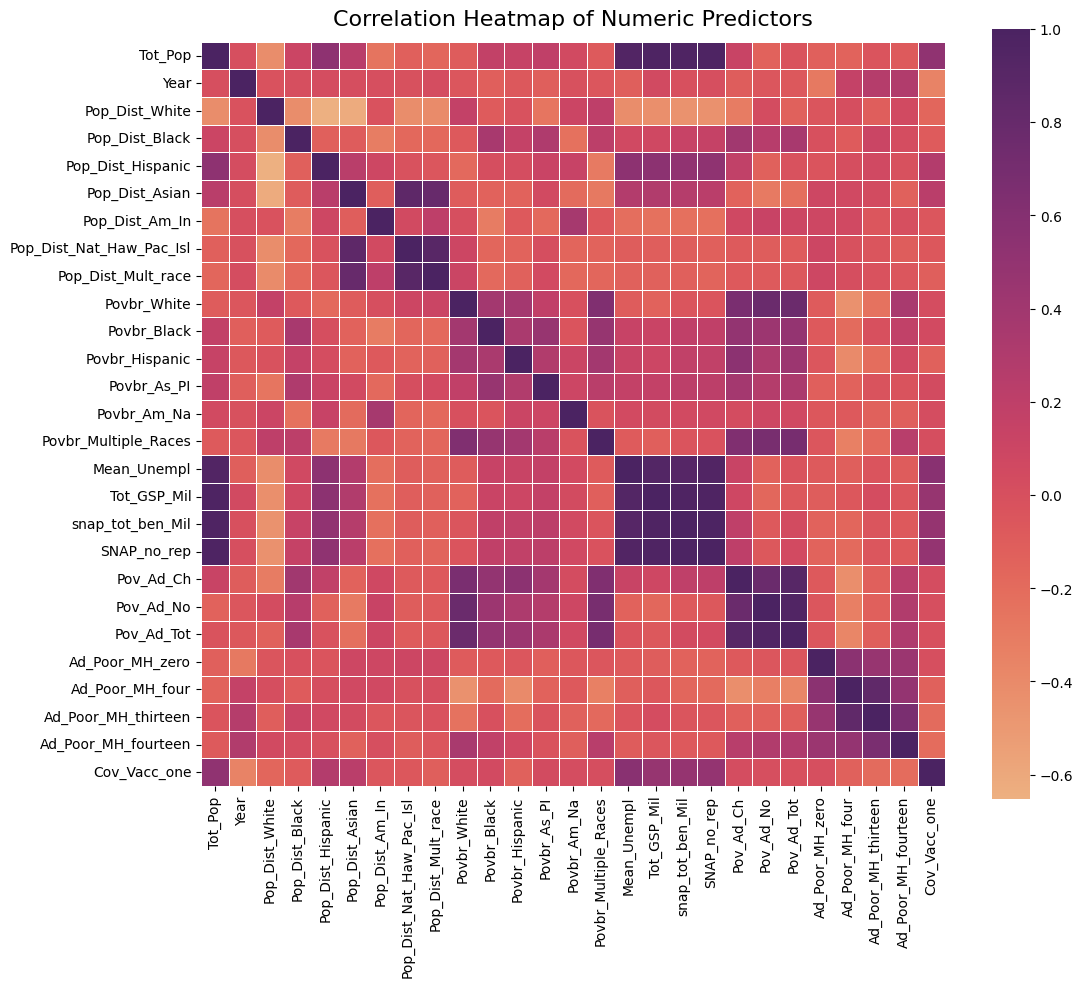

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    cmap="flare",   # <-- use flare color scheme
    annot=False,    # set True to show correlation values
    cbar=True,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Heatmap of Numeric Predictors", fontsize=16, pad=12)
plt.show()

In [8]:
predictors_A = ["Tot_Pop", "Mean_Unempl", "Pov_Ad_Tot", "Ad_Poor_MH_fourteen"]

X_A = data_clean[predictors_A].fillna(0)
y_A = data_clean["Cov_Vacc_one"].dropna()

# Align indices in case of missing targets
idxA = X_A.index.intersection(y_A.index)
X_A_const = sm.add_constant(X_A.loc[idxA])
y_A = y_A.loc[idxA]

ols_A = sm.OLS(y_A, X_A_const).fit()
print(ols_A.summary())

                            OLS Regression Results                            
Dep. Variable:           Cov_Vacc_one   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     18.85
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.70e-12
Time:                        16:26:57   Log-Likelihood:                -3299.0
No. Observations:                 150   AIC:                             6608.
Df Residuals:                     145   BIC:                             6623.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                7.977e+08   4

In [9]:
predictors_B = ["Tot_Pop", "Mean_Unempl", "Pov_Ad_Tot", "Ad_Poor_MH_fourteen", "Cov_Vacc_one"]

X_B = data_clean[predictors_B].fillna(0)
y_B = data_clean["Tot_GSP_Mil"]

X_B_const = sm.add_constant(X_B)
ols_B = sm.OLS(y_B, X_B_const).fit()
print(ols_B.summary())

                            OLS Regression Results                            
Dep. Variable:            Tot_GSP_Mil   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     674.8
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.89e-99
Time:                        16:27:08   Log-Likelihood:                -2020.6
No. Observations:                 153   AIC:                             4053.
Df Residuals:                     147   BIC:                             4071.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2120.3962   6

In [11]:
from sklearn.preprocessing import StandardScaler

# Define reduced predictor sets for comparison
predictors_reduced = ["Tot_Pop", "Mean_Unempl", "Pov_Ad_Tot", "Ad_Poor_MH_fourteen", "Cov_Vacc_one"]

X = data_clean[predictors_reduced].fillna(0)
y = data_clean["Tot_GSP_Mil"]

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Means after scaling:", X_scaled.mean(axis=0))
print("Standard deviations after scaling:", X_scaled.std(axis=0))

Means after scaling: [ 7.98199560e-18 -1.16101754e-17 -2.14788245e-16  6.96610525e-17
  0.00000000e+00]
Standard deviations after scaling: [1. 1. 1. 1. 1.]


In [12]:
# Add intercept manually since sklearn scaling removed mean
X_scaled_const = sm.add_constant(X_scaled)
ols_std = sm.OLS(y, X_scaled_const).fit()
print(ols_std.summary())

                            OLS Regression Results                            
Dep. Variable:            Tot_GSP_Mil   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     674.8
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.89e-99
Time:                        16:28:19   Log-Likelihood:                -2020.6
No. Observations:                 153   AIC:                             4053.
Df Residuals:                     147   BIC:                             4071.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.987e+05   1.09e+04     45.925      0.0

Optimal alpha: 3852.0067208037112

LASSO Coefficients:
Tot_Pop                520827.001075
Mean_Unempl            128291.703786
Pov_Ad_Tot             -26310.211196
Ad_Poor_MH_fourteen     18449.121461
Cov_Vacc_one           -32983.829204
dtype: float64


<Axes: title={'center': 'LASSO Coefficients'}>

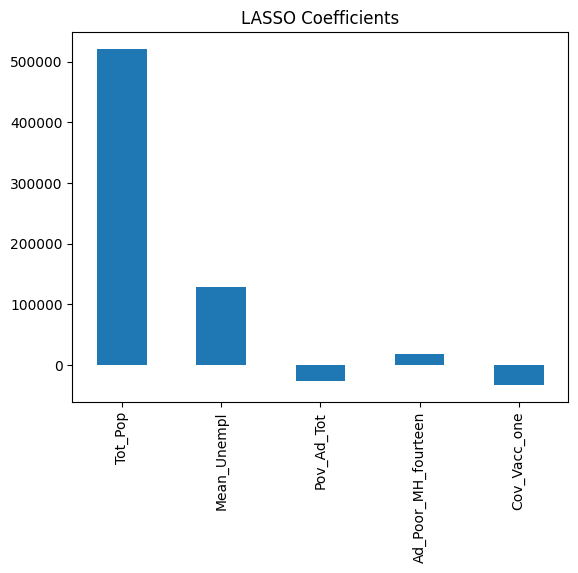

In [13]:
from sklearn.linear_model import LassoCV
import numpy as np

# Cross-validated LASSO
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)

# Coefficients
coef_lasso = pd.Series(lasso.coef_, index=predictors_reduced)
print("Optimal alpha:", lasso.alpha_)
print("\nLASSO Coefficients:")
print(coef_lasso)

# Show which coefficients survive shrinkage
coef_lasso.plot(kind="bar", title="LASSO Coefficients")
